## Load the datasets and display sample data of the datasets

In [1]:
# load the data from the three sheets
import pandas as pd
# wind power usage data (wpu)
wpu = pd.read_excel('MidwestData.xlsx',sheet_name='Wind Power Usage', skiprows=2)
# wind energy price data (wep)
wep = pd.read_excel('MidwestData.xlsx', sheet_name='Wind Energy Price',skiprows=3)
# wind energy cost data (wec)
wec = pd.read_excel('MidwestData.xlsx', sheet_name='Wind Energy Cost',skiprows=3)

In [2]:
# display sample of the wind power usage dataset
wpu.head()

,Year,Illinois Capacity,Illinois Generation,Illinois %,Kansas Capacity,Kansas Generation,Kansas %,Lowa Capacity,Lowa Generation,Lowa %,...,Missouri %,Michigan Capacity,Michigan Generation,Michigan %,Ohio Capacity,Ohio Generation,Ohio %,Wisconsin Capacity,Wisconsin Generation,Wisconsin %
0,2013,3568,7200,0.045,2967,7500,0.12,5177,15300,0.27,...,0.015,320,800,0.010,420,900,0.008,280,600,0.010
1,2014,3842,8100,0.051,3776,9800,0.17,5688,16900,0.31,...,0.020,450,1100,0.014,500,1100,0.010,350,800,0.013
2,2015,4011,8900,0.058,4451,12100,0.22,6212,18500,0.35,...,0.026,650,1600,0.020,600,1400,0.013,450,1000,0.016
3,2016,4317,9500,0.063,5110,14900,0.30,6974,20800,0.37,...,0.034,850,2100,0.026,700,1700,0.016,550,1300,0.020
4,2017,4650,10200,0.069,5653,16300,0.36,7312,22100,0.40,...,0.043,1050,2600,0.032,800,2000,0.019,650,1500,0.023


In [3]:
# display sample of the wind energy price dataset
wep.head()

,Year,Iowa,Illinois,Minnesota,Kansas,North Dakota,South Dakota,Nebraska,Missouri,Wisconsin,Michigan,Indiana,Ohio
0,2013,32,38,36,29,32,33,31,35,36,37,38,39
1,2014,30,35,34,27,30,31,29,33,34,35,36,37
2,2015,28,33,31,25,28,29,27,31,32,33,34,35
3,2016,25,30,28,22,25,26,24,28,29,30,31,32
4,2017,22,27,25,20,22,23,21,25,26,27,28,29


In [4]:
# display sample of the wind energy cost dataset
wec.head()

,Year,Iowa,Illinois,Minnesota,Kansas,Nebraska,North Dakota,South Dakota,Missouri,Michigan,Ohio,Wisconsin,Indiana
0,2013,68,75,72,62,70,65,63,78,82,85,80,77
1,2015,55,63,60,50,58,53,51,65,70,73,68,64
2,2017,42,50,47,38,45,40,38,52,58,62,55,50
3,2019,34,42,39,30,37,32,30,44,50,54,47,42
4,2021,38,46,43,34,41,36,34,48,54,58,51,46


## Melt the datasets: create dataframes for capacity, generation, ppa price, and lcoe

In [5]:
# the following lines of codes defines the column names for capacity, generation, and % of state capacity for the states
# these column names will be used for melting the data into dataframes representing capacity, generation, and %
capacity_names = ['Illinois Capacity','Kansas Capacity','Lowa Capacity','Minnesota Capacity', 'Nebraska Capacity','North Dakota Capacity', 'South Dakota Capacity', 'Indiana Capacity', 'Missouri Capacity', 'Michigan Capacity','Ohio Capacity', 'Wisconsin Capacity']
Gen_names = ['Illinois Generation','Kansas Generation','Lowa Generation','Minnesota Generation', 'Nebraska Generation','North Dakota Generation', 'South Dakota Generation', 'Indiana Generation', 'Missouri Generation', 'Michigan Generation','Ohio Generation', 'Wisconsin Generation']

# Melt the data for wind capacity into long data
capacity = pd.melt(wpu, id_vars=['Year'],value_vars=capacity_names, var_name='item_id', value_name='target')
capacity['Year'] = pd.to_datetime(capacity['Year'], format='%Y') # convert year column to long time for working autogluon

# Melt the data for wind generation into long data
generation = pd.melt(wpu, id_vars=['Year'],value_vars=Gen_names, var_name='item_id', value_name='target')
generation['Year'] = pd.to_datetime(generation['Year'], format='%Y')

# Melt the data for wind average ppa price into long data
ppa_price = pd.melt(wep, id_vars=['Year'],value_vars=wep.columns.to_list().remove('Year'), var_name='item_id', value_name='target')
ppa_price['Year'] = pd.to_datetime(ppa_price['Year'], format='%Y')

# Melt the data for Average LCOE into long data
lcoe = pd.melt(wec, id_vars=['Year'],value_vars=wec.columns.to_list().remove('Year'), var_name='item_id', value_name='target')
lcoe['Year'] = pd.to_datetime(lcoe['Year'], format='%Y')
capacity.head()

,Year,item_id,target
0,2013-01-01,Illinois Capacity,3568
1,2014-01-01,Illinois Capacity,3842
2,2015-01-01,Illinois Capacity,4011
3,2016-01-01,Illinois Capacity,4317
4,2017-01-01,Illinois Capacity,4650


## Convert the dataset into autogluon time series

In [6]:
# construct a time series dataframe for autogluon
from autogluon.timeseries import TimeSeriesDataFrame
capacity_ts = TimeSeriesDataFrame.from_data_frame(capacity,id_column='item_id', timestamp_column='Year')
generation_ts = TimeSeriesDataFrame.from_data_frame(generation,id_column='item_id', timestamp_column='Year')
ppa_price_ts = TimeSeriesDataFrame.from_data_frame(ppa_price,id_column='item_id', timestamp_column='Year')
lcoe_ts = TimeSeriesDataFrame.from_data_frame(lcoe,id_column='item_id', timestamp_column='Year')
capacity_ts.head()

target
item_id           timestamp         
Illinois Capacity 2013-01-01    3568
                  2014-01-01    3842
                  2015-01-01    4011
                  2016-01-01    4317
                  2017-01-01    4650

## Split the data into train and test sets

In [7]:
# split the datasets into training and test dataset for model training and validation purposes
capacity_train, capacity_test = capacity_ts.train_test_split(prediction_length=1)
gen_train, gen_test = generation_ts.train_test_split(prediction_length=1)
ppa_train, ppa_test = ppa_price_ts.train_test_split(prediction_length=1)
lcoe_train, lcoe_test = lcoe_ts.train_test_split(prediction_length=1)

Sorting the dataframe index before generating the train/test split.
Sorting the dataframe index before generating the train/test split.
Sorting the dataframe index before generating the train/test split.
Sorting the dataframe index before generating the train/test split.


In [8]:
capacity_train.shape, capacity_test.shape

((120, 1), (132, 1))

## Train the time series models using autogluon

### TS model to forecast  wind capacity

In [11]:
from autogluon.timeseries import TimeSeriesPredictor
# first create a time series predictor object
capacity_predictor = TimeSeriesPredictor(
    prediction_length=4,
    path='d:\Documents\/auto_gluon_capacity',
    target='target',
    eval_metric='RMSE',
)

# fit DeepAR, ETS, AutoARIMA, and Theta models to forecast wind capacity
capacity_predictor.fit(train_data=capacity_train, presets='high_quality',
                       hyperparameters={
                           'DeepAR':{},
                           'ETS':{},
                           'AutoARIMA':{},
                           'Theta':{}
                       })

Beginning AutoGluon training...
AutoGluon will save models to 'd:\Documents\auto_gluon_capacity'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       1.58 GB / 7.85 GB (20.1%)
Disk Space Avail:   33.65 GB / 70.00 GB (48.1%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': {'AutoARIMA': {}, 'DeepAR': {}, 'ETS': {}, 'Theta': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 4,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'YS-JAN'
Provided train_data has 120 rows, 12 time series. Median time se

Model not specified in predict, will default to the model with the best validation score: AutoARIMA


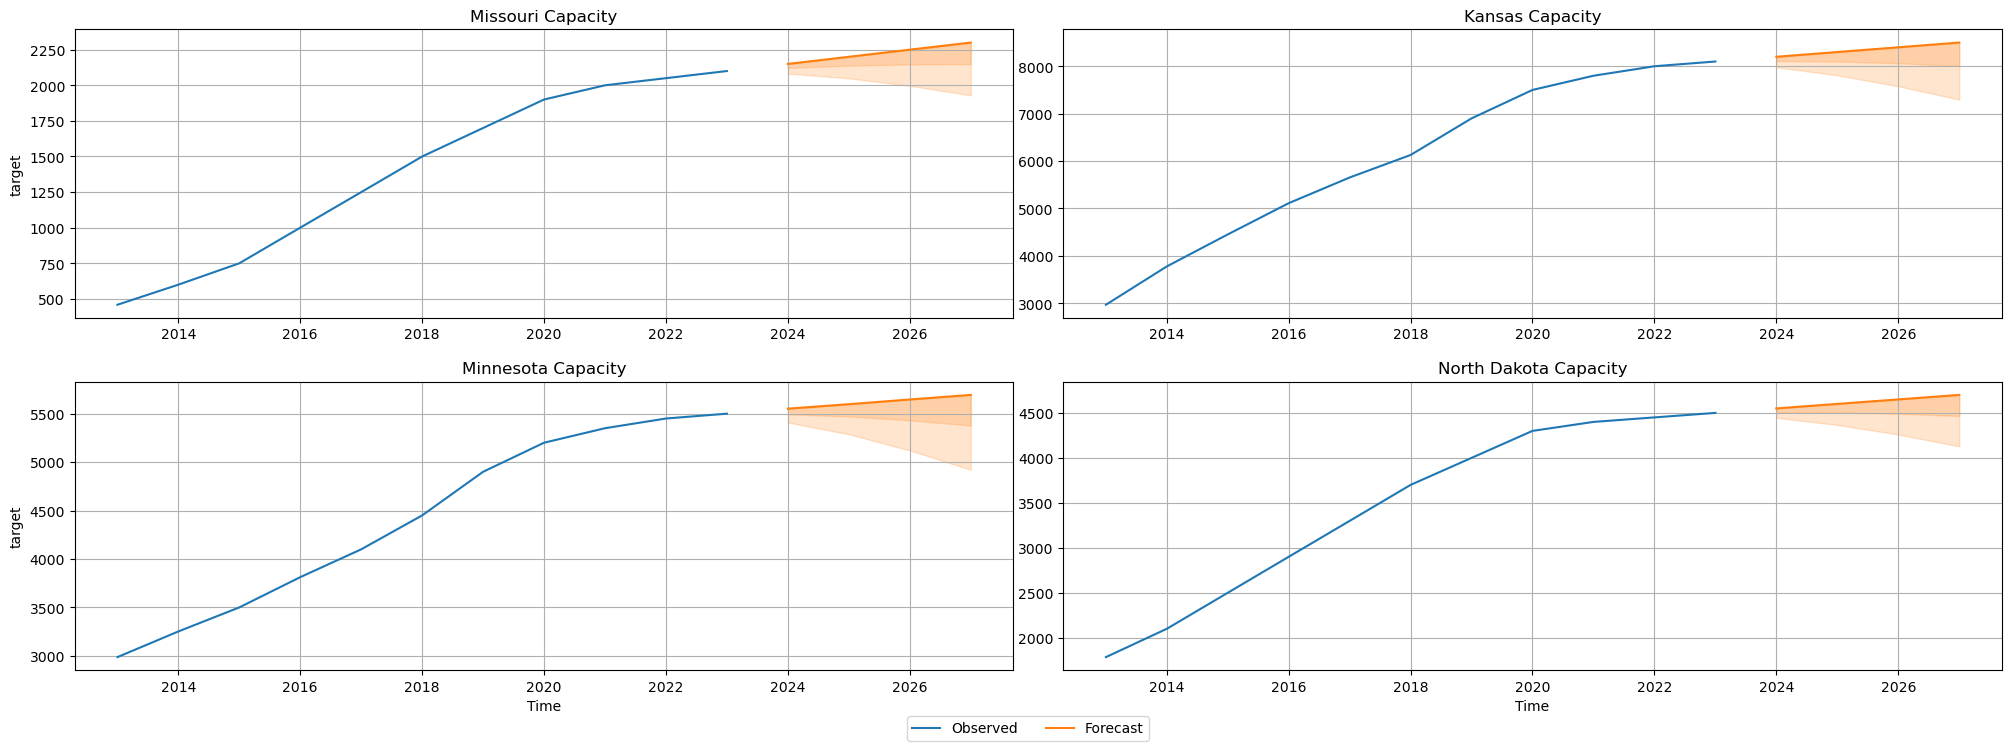

In [14]:
# make predictions
capacity_preds = capacity_predictor.predict(capacity_test)
# Plot 4 randomly chosen time series and the respective forecasts
capacity_predictor.plot(capacity_test, capacity_preds, quantile_levels=[0.1, 0.3], max_history_length=200, max_num_item_ids=4)

In [15]:
# Evaluate the performance different models on the test data
capacity_predictor.leaderboard(capacity_test)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,Theta,-463.790008,-836.807763,0.163993,57.691998,0.042917,2
1,WeightedEnsemble,-560.544514,-621.445472,2.075735,1.631102,0.749020,5
2,AutoARIMA,-560.544514,-621.445472,2.043729,1.631102,0.075011,3
3,ETS,-855.504429,-1247.573795,0.190962,22.494947,0.053940,1
4,DeepAR,-994.084626,-1136.630822,0.394795,0.130963,119.732465,4


### TS Model to Forecast PPA Prices

In [16]:
# first create a time series predictor object
ppa_predictor = TimeSeriesPredictor(
    prediction_length=4,
    path='d:\Documents\/auto_gluon_ppa',
    target='target',
    eval_metric='RMSE',
)

# fit DeepAR, ETS, AutoARIMA, and Theta models to forecast wind PPA Prices
ppa_predictor.fit(train_data=ppa_train, presets='high_quality',
                       hyperparameters={
                           'DeepAR':{},
                           'ETS':{},
                           'AutoARIMA':{},
                           'Theta':{}
                       })

Beginning AutoGluon training...
AutoGluon will save models to 'd:\Documents\auto_gluon_ppa'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       1.24 GB / 7.85 GB (15.8%)
Disk Space Avail:   33.65 GB / 70.00 GB (48.1%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': {'AutoARIMA': {}, 'DeepAR': {}, 'ETS': {}, 'Theta': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 4,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'YS-JAN'
Provided train_data has 120 rows, 12 time series. Median time series 

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


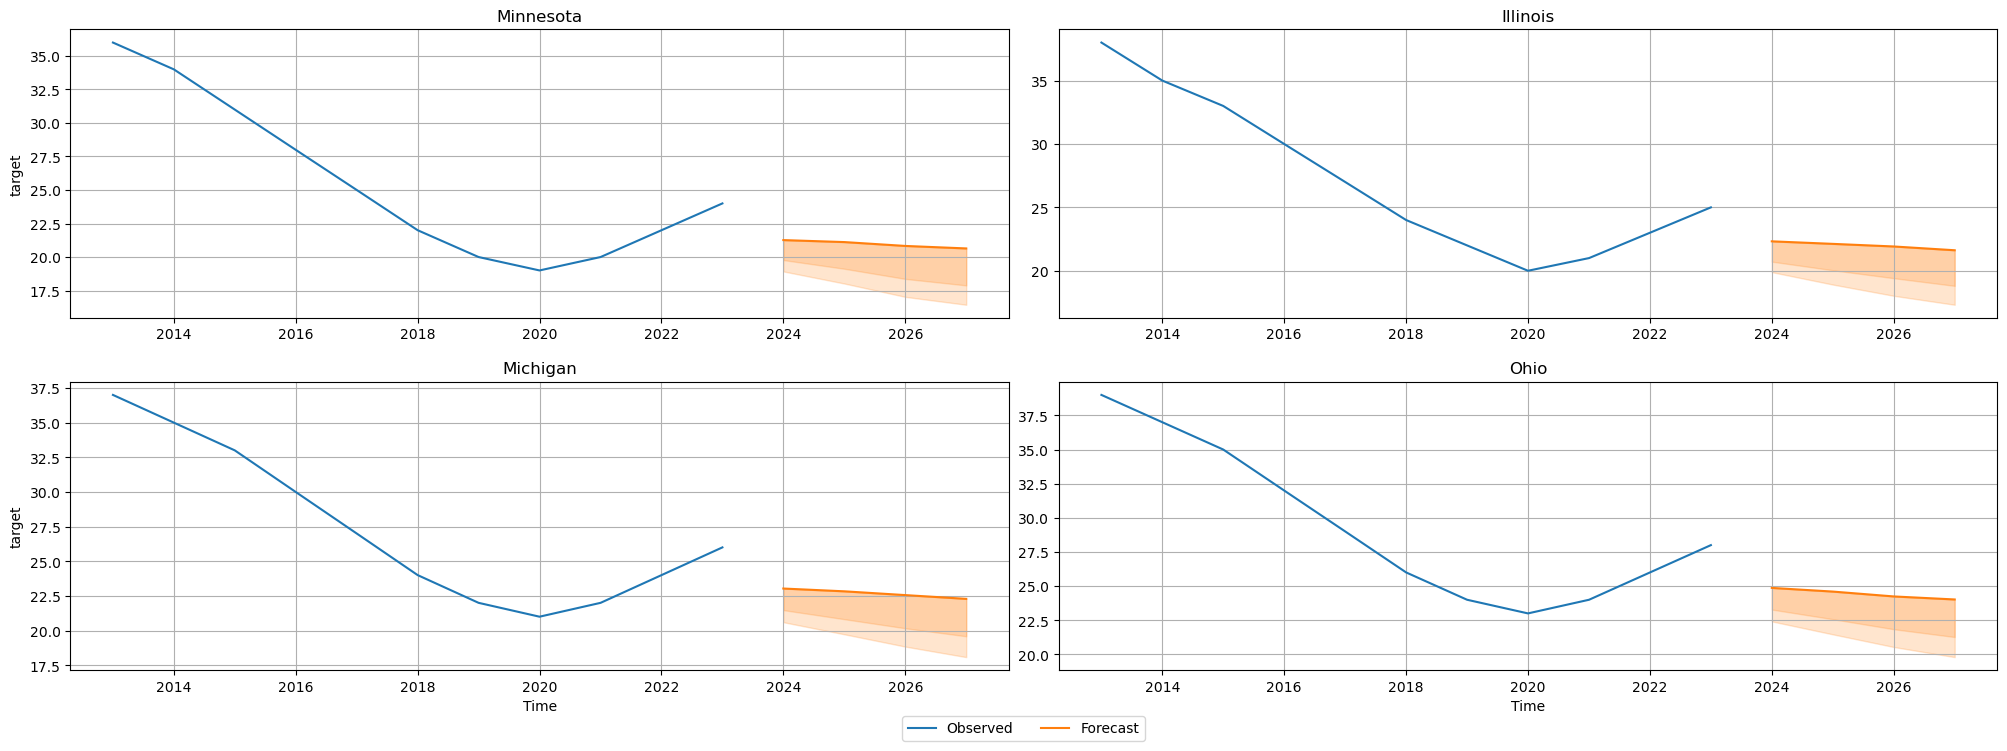

In [17]:
# make predictions
ppa_preds = ppa_predictor.predict(ppa_test)
# Plot 4 randomly chosen time series and the respective forecasts
ppa_predictor.plot(ppa_test, ppa_preds, quantile_levels=[0.1, 0.2], max_history_length=200, max_num_item_ids=4)

In [18]:
# Evaluate the performance different models on the test data
ppa_predictor.leaderboard(ppa_test)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ETS,-2.263743,-2.126225,0.112224,0.146042,0.041431,1
1,WeightedEnsemble,-3.190134,-1.385362,0.351525,0.281875,1.134454,5
2,DeepAR,-4.778632,-2.748619,0.236273,0.135833,103.063764,4
3,Theta,-5.472619,-2.731594,0.250170,0.112644,0.036323,2
4,AutoARIMA,-6.659201,-3.852003,1.926180,3.217744,0.032470,3


### TS Model to Forecast Wind Generation

In [19]:
# first create a time series predictor object
gen_predictor = TimeSeriesPredictor(
    prediction_length=4,
    path='d:\Documents\/auto_gluon_generation',
    target='target',
    eval_metric='RMSE',
)

# fit DeepAR, ETS, AutoARIMA, and Theta models to forecast wind generation
gen_predictor.fit(train_data=gen_train, presets='high_quality',
                       hyperparameters={
                           'DeepAR':{},
                           'ETS':{},
                           'AutoARIMA':{},
                           'Theta':{}
                       })

Beginning AutoGluon training...
AutoGluon will save models to 'd:\Documents\auto_gluon_generation'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.7
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          8
GPU Count:          0
Memory Avail:       1.50 GB / 7.85 GB (19.1%)
Disk Space Avail:   33.65 GB / 70.00 GB (48.1%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': {'AutoARIMA': {}, 'DeepAR': {}, 'ETS': {}, 'Theta': {}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 4,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'YS-JAN'
Provided train_data has 120 rows, 12 time series. Median time 

Model not specified in predict, will default to the model with the best validation score: DeepAR


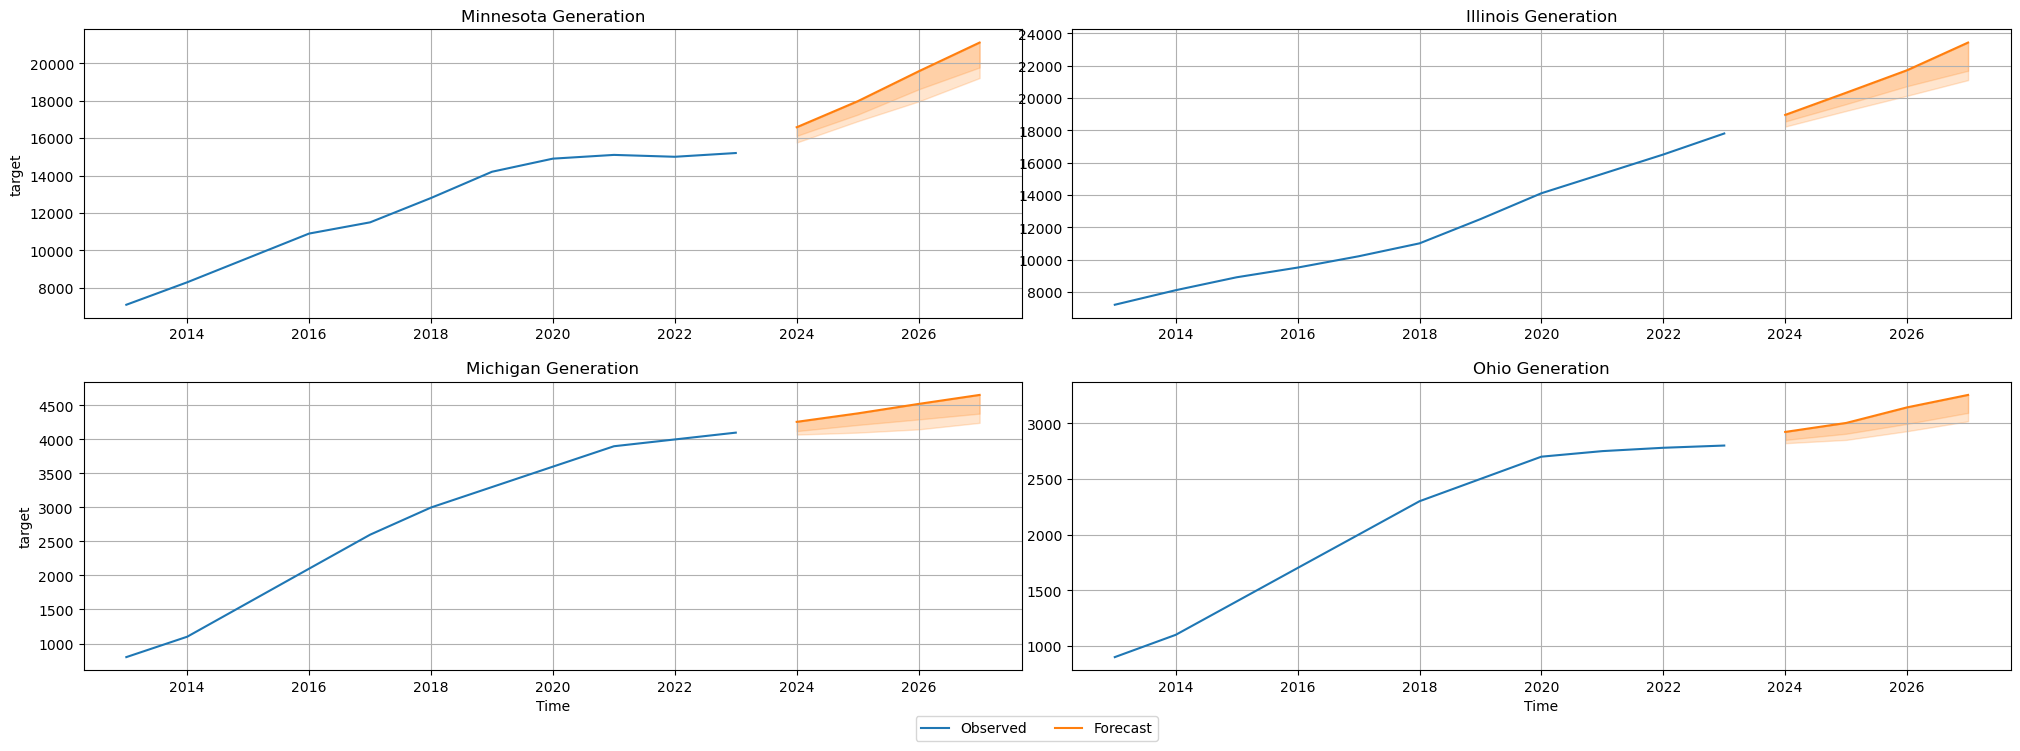

In [20]:
# make predictions
gen_preds = gen_predictor.predict(gen_test)
# Plot 4 randomly chosen time series and the respective forecasts
gen_predictor.plot(gen_test, gen_preds, quantile_levels=[0.1, 0.2], max_history_length=200, max_num_item_ids=4)

In [21]:
# Evaluate the performance different models on the test data
gen_predictor.leaderboard(gen_test)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,AutoARIMA,-1964.444928,-2353.916969,1.801568,2.523084,0.035655,3
1,Theta,-2428.139262,-2839.128141,0.161724,0.126297,0.036257,2
2,WeightedEnsemble,-2472.945991,-1806.041417,0.191609,0.088858,0.790259,5
3,DeepAR,-2472.945991,-1806.041417,0.161822,0.088858,95.536440,4
4,ETS,-3424.767144,-4067.036954,0.250635,0.129159,0.060091,1
